**Problem 3.2**

In [99]:
# The workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.special

# Numerical differentiation packages
import numdifftools as ndt

# Plotting modules
import matplotlib.pyplot as plt

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

**a)** We are asked to comment on the choice of a Gaussian-plus-background function to fit the data. First, we need to read in the dataset.

In [26]:
df= pd.read_csv("data/reeves_et_al/reeves_dv_profile_over_time.csv", comment="#")

#each column in original dataset represents ListOfNuclearCycles
ListOfNuclearCycles=["14","14","13","13","12","12","11","11"]

VarNames = ["DVCoordinate","Intensity"]*4

df.columns=pd.MultiIndex.from_arrays((ListOfNuclearCycles, VarNames), 
                                        names=['NC', ''])

#getting a tidy dataset. the dataframe was not big, hence we just do it manually

TidyData=pd.concat((df["14"],df["13"],df["12"],df["11"])).reset_index(drop=True)
ListOfNC=sum(list(([int("14")]*44,[int("13")]*44,[int("12")]*44,[int("11")]*44)),[])
TidyData["NuclearCycle"]=ListOfNC
TidyData = TidyData.dropna().reset_index(drop=True)
TidyData.head()

,DVCoordinate,Intensity,NuclearCycle
0,0.7813,1.6512,14
1,0.8565,1.4200,14
2,0.8986,1.3845,14
3,0.9286,1.3960,14
4,-0.9356,1.1741,14


Next, let's make plots of fluorescence intensity vs. DV coordinate for each of the nuclear cycles.

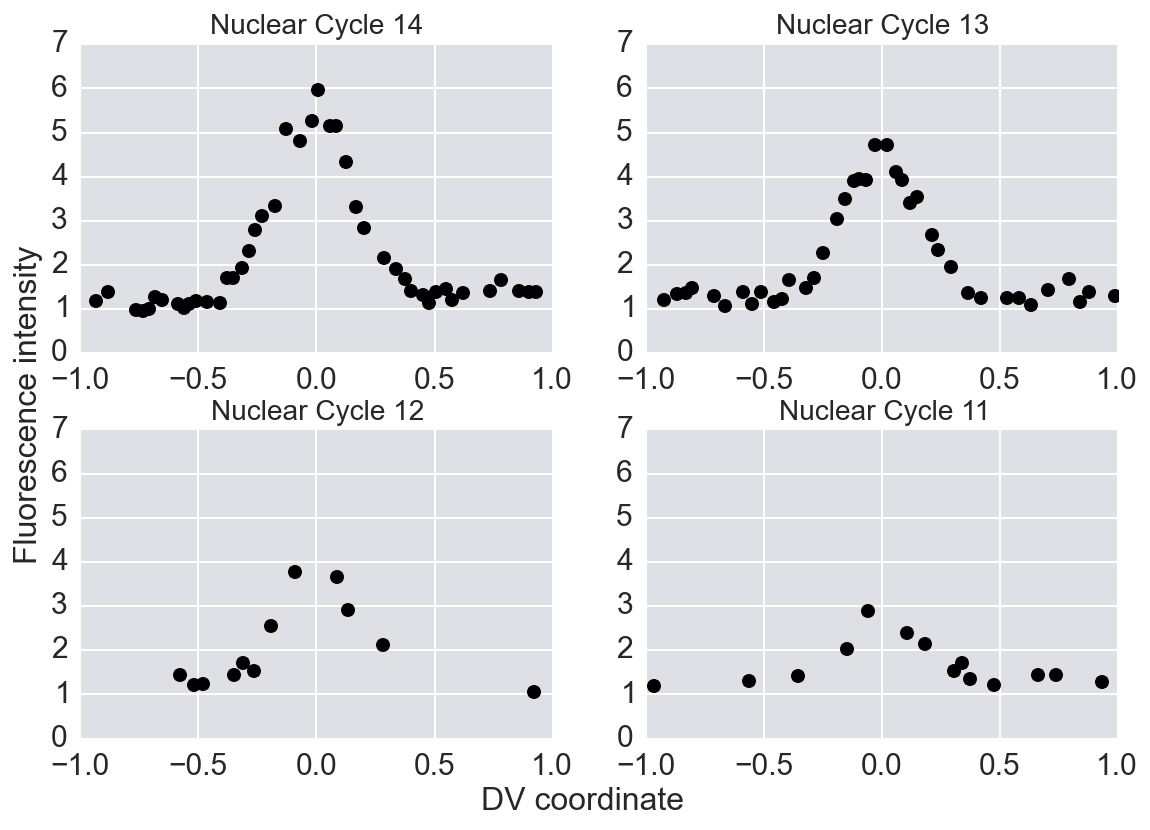

In [68]:
# For convenience, slice the original tidy DataFrame by nuclear cycle
nc14 = TidyData[TidyData['NuclearCycle']==14]
nc13 = TidyData[TidyData['NuclearCycle']==13]
nc12 = TidyData[TidyData['NuclearCycle']==12]
nc11 = TidyData[TidyData['NuclearCycle']==11]

# Make subplots
f, ax = plt.subplots(2, 2)

f.tight_layout()
ax[0,0].plot(nc14['DVCoordinate'], nc14['Intensity'], marker='o', linestyle='none', color='black')
ax[0,0].set_ylim([0,7.0])
ax[0,0].set_title('Nuclear Cycle 14', fontsize=14)
ax[0,1].plot(nc13['DVCoordinate'], nc13['Intensity'], marker='o', linestyle='none', color='black')
ax[0,1].set_ylim([0,7.0])
ax[0,1].set_title('Nuclear Cycle 13', fontsize=14)
ax[1,0].plot(nc12['DVCoordinate'], nc12['Intensity'], marker='o', linestyle='none', color='black')
ax[1,0].set_ylim([0,7.0])
ax[1,0].set_xlim([-1.0,1.0])
ax[1,0].set_title('Nuclear Cycle 12', fontsize=14)
ax[1,1].plot(nc11['DVCoordinate'], nc11['Intensity'], marker='o', linestyle='none', color='black')
ax[1,1].set_ylim([0,7.0])
ax[1,1].set_title('Nuclear Cycle 11', fontsize=14)

# Set common labels
f.text(0.5, 0.0, 'DV coordinate', ha='center', va='center', fontsize=16)
f.text(0.02, 0.5, 'Fluorescence intensity', ha='center', va='center', rotation='vertical', fontsize=16)

**comment on choice of Gaussian**

**b)**  We are asked to write down expressions for the likelihood, prior, and posterior for a regression of these data.

First, the likelihood. We assume that the data vary from our model in a Gaussian manner. (This assumption is based on the central limit theorem, which is applicable in this case because many processes contribute to noise in the expression of a gene - e.g. the binding of transcription factors, the binding of the polymerase, errors in transcription, binding to the ribosome, etc.). Thus, our likelihood is given by:

\begin{align}
P(D \mid A, B, s, \sigma, I) = \prod_{i\in D} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left[-\frac{(F_i - F(c_i;A, B, s))^2}{2\sigma^2}\right],
\end{align}

where

\begin{align}
F(c; A, B, s) = A \exp\left[-\frac{c^2}{2s^2}\right] \, + \, B
\end{align}

Next, the prior. We want the most uninformative priors for each of the parameters, since we assume that we do not know anything about expression of Dorsal in this system *a priori* and we want to avoid biasing the posterior distribution. We have four parameters: $A, B, s, \sigma$. We choose a Jeffreys prior for $A$, $s$, and $\sigma$ because they are scaling parameters. $B$ is a location parameter (it moves the Gaussian curve up or down without changing the shape of the curve), so we choose a uniform prior for $B$. **A quick look at our dataset reveals that the minimum fluorescence intensity is 0.95.** We will set the lower bound for $B$ as zero because it doesn't make sense physically to have a negative background signal, and we will set the upper bound of $B$ to be well beyond the minimum recorded fluorescence intensity so that the posterior will be vanishingly small at the upper bound. We arbitrarily choose this upper bound to be 10. So our prior can be written as:

\begin{align}
P(A, B, s, \sigma \mid I) = P(A \mid I)P(B \mid I)P(s \mid I)P(\sigma \mid I) = \left\{
\begin{array}{cl}
(As\sigma)^{-1} & 0 \leq B \leq 10, \, A > 0, \, s > 0, \, \sigma > 0\\
0 & \mathrm{otherwise}
\end{array}
\right.
\end{align}

Now we can put the likelihood and prior together to write an expression for the posterior. We don't care about the normalization constant given by $P(D \mid I)$, so we will write the posterior as a statement of proportionality: 

\begin{align}
P(A, B, s, \sigma \mid D, I) \propto\frac{1}{\sigma^{n+1}}
\exp\left[-\frac{1}{2\sigma^2}\sum_{i\in D}(F_i - F(c_i; A, B, s))^2\right],
\end{align}

where

\begin{align}
F(c; A, B, s) = A \exp\left[-\frac{c^2}{2s^2}\right] \, + \, B
\end{align}

Marginalizing the posterior over $\sigma$ gives a Student-t distribution:

\begin{align}
P(A, B, s \mid D, I) \propto \left(\sum_{i\in D}(F_i - F(c_i; A, B, s)^2\right)^{-\frac{n}{2}} .
\end{align}

**c)** First, let's define a Python function for our theoretical model.

In [17]:
def fluor(c, A, B, s):
    """
    Theoretical model for fluorescence intensity (i.e. Dorsal expression) as a function of position c
    along the DV coordinate axis. 
    """
    return A * np.exp(-(c**2)/(2 * s**2)) + B

Next, we define a residual function, where the residual is the difference between the theoretical model prediction and the measured fluorescence intensity. 

In [78]:
def resid(p, c, f):
    """
    Residuals for Dorsal gradient model.
    """
    # Unpack parameters
    A, B, s = p
    
    # Compute residuals
    return f - fluor(c, A, B, s)

We have to provide an initial guess for the parameter values. Looking at the data in our plot above for nuclear cycle 14 (part **a**), we guess $A = 6.0, \, B = 1.0, \, s = 0.25$. (Remember that $A$ is the amplitude, or approximately the maximum fluorescence value; $B$ is the background, which is approximately the mimimum value; and $s$ is the width of the bell curve.) We make our guesses for the parameters for the other nuclear cycles in a similar manner.

In [91]:
p0 = np.array([[6.0, 1.0, 0.25],[5.0, 1.0, 0.25], [4.0, 1.0, 0.25], [3.0, 1.0, 0.25]])

array([ 0.,  0.,  0.,  0.])

Now we can use `scipy.optimize.leastsq()` to compute the MAP.

In [114]:
# First define a function for log of the posterior, 
# to be used when calculating error bars for the regression parameters
def log_post(p, c, f):
    """
    Compute log of posterior for single set of parameters.
    p[0] = A
    p[1] = B
    p[2] = s
    """
    # Unpack parameters
    A, B, s = p
    
    # Theoretical spindle length
    f_theor = fluor(c, A, B, s)
    
    return -len(c) / 2 * np.log(np.sum((f - f_theor)**2))

# Extra arguments as a tuple
args = ((nc14['DVCoordinate'], nc14['Intensity']),(nc13['DVCoordinate'], nc13['Intensity']),
        (nc12['DVCoordinate'], nc12['Intensity']),(nc11['DVCoordinate'], nc11['Intensity']))

A_list = []
B_list = []
s_list = []
cov = []

# Compute the MAP
for i in range(0,4):
    popt, _ = scipy.optimize.leastsq(resid, p0[i], args=args[i])

    # Extract the values
    A, B, s = popt
    A_list.append(A)
    B_list.append(B)
    s_list.append(s)

    # Instantiate Hessian for log posterior
    hes_fun = ndt.Hessian(log_post)

    # Compute Hessian at MAP
    hes = hes_fun(popt, args[i][0], args[i][1])
    
    # Compute the covariance matrix
    cov.append(list(-np.linalg.inv(hes)))

# Print results
print("""
Most probable parameters for nuclear cycle 14
---------------------------------------------
A = {0:.2f} ± {1:.2f}
B = {2:.2f} ± {3:.2f}
s = {4:.2f} ± {5:.2f}
""".format(A_list[0], np.sqrt(cov[0][0][0]), 
           B_list[0], np.sqrt(cov[0][1][1]), 
           s_list[0], np.sqrt(abs(cov[0][2][2]))))

print("""
Most probable parameters for nuclear cycle 13
---------------------------------------------
A = {0:.2f} ± {1:.2f}
B = {2:.2f} ± {3:.2f}
s = {4:.2f} ± {5:.2f}
""".format(A_list[1], np.sqrt(cov[1][0][0]), 
           B_list[1], np.sqrt(cov[1][1][1]), 
           s_list[1], np.sqrt(abs(cov[1][2][2]))))

print("""
Most probable parameters for nuclear cycle 12
---------------------------------------------
A = {0:.2f} ± {1:.2f}
B = {2:.2f} ± {3:.2f}
s = {4:.2f} ± {5:.2f}
""".format(A_list[2], np.sqrt(cov[2][0][0]), 
           B_list[2], np.sqrt(cov[2][1][1]), 
           s_list[2], np.sqrt(abs(cov[2][2][2]))))

print("""
Most probable parameters for nuclear cycle 11
---------------------------------------------
A = {0:.2f} ± {1:.2f}
B = {2:.2f} ± {3:.2f}
s = {4:.2f} ± {5:.2f}
""".format(A_list[3], np.sqrt(cov[3][0][0]), 
           B_list[3], np.sqrt(cov[3][1][1]), 
           s_list[3], np.sqrt(abs(cov[3][2][2]))))


Most probable parameters for nuclear cycle 14
---------------------------------------------
A = 4.26 ± 0.11
B = 1.24 ± 0.04
s = 0.16 ± 0.11


Most probable parameters for nuclear cycle 13
---------------------------------------------
A = 3.25 ± 0.08
B = 1.28 ± 0.03
s = 0.16 ± 0.12


Most probable parameters for nuclear cycle 12
---------------------------------------------
A = 2.82 ± 0.13
B = 1.25 ± 0.00
s = 0.15 ± 0.01


Most probable parameters for nuclear cycle 11
---------------------------------------------
A = 1.48 ± 0.13
B = 1.32 ± 0.05
s = 0.15 ± 0.02



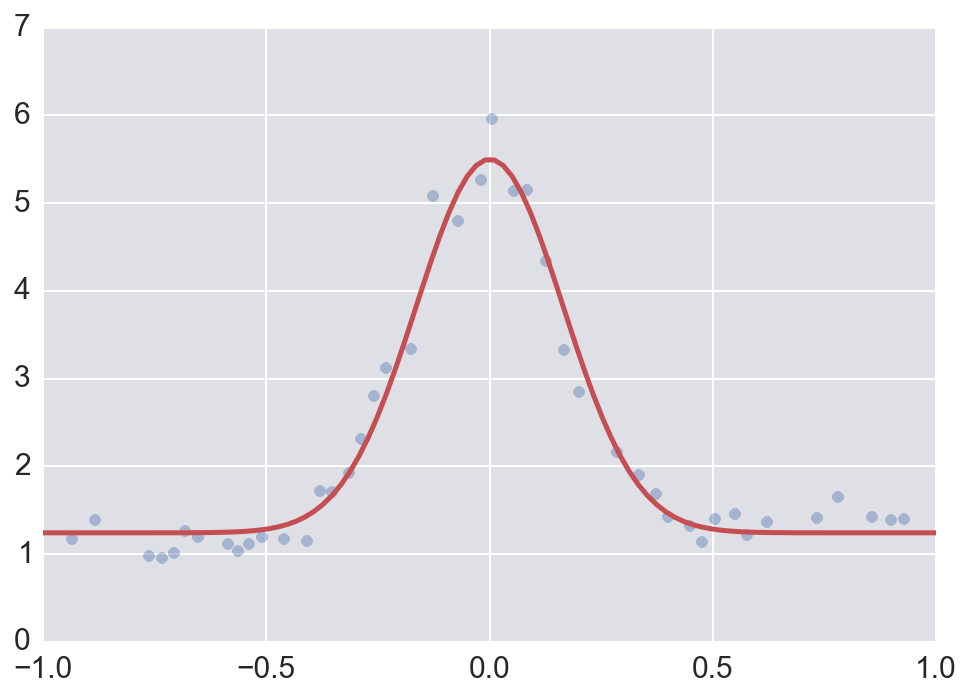

In [76]:
# Values of DV coordinate to plot
dv_plot = np.linspace(-1, 1, 100)

# Theoretical curve
fluor_theor = fluor(dv_plot, A, B, s)

# Plot data
plt.plot(nc14['DVCoordinate'], nc14['Intensity'], '.', 
         markersize=12, alpha=0.4)

# Plot the regression curve
plt.plot(dv_plot, fluor_theor, '-', color=sns.color_palette()[2])
_ = plt.ylim([0,7])